# Data pre-processing for SMA data

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import glob
import cv2
import matplotlib.pyplot as plt

### Define the path

In [2]:
mouse = 'V11L12-109'
root = '/home/wzk/ST_data/SMA_data/Zhikang'
save_dir = '/home/wzk/ST_data/SMA_data/Processed_data_v4'
n_top_msi = 50

# for sample 1
path_rna = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_A1/output_data/V11L12-109_A1_RNA/outs'
path_meta = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_A1/output_data/V11L12-109_A1_MSI/V11L12-109_A1.Visium.FMP.220826_smamsi.csv'
points_rna = [[18, 10], [55, 11], [60, 12], [65, 13], [54, 18], [98, 32], [125, 58], [46, 35], [71, 44], [50, 62]]
points_meta = [[15, 0], [34, 1], [37, 2], [40, 3], [32, 6], [53, 18], [65, 46], [28, 20], [41, 28], [24, 40]]

## for sample 2
# path_rna = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs'
# path_meta = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_MSI/V11L12-109_B1.Visium.FMP.220826_smamsi.csv'
# points_rna = [[11, 3], [37, 3], [13, 21], [51, 5], [55, 15], [83, 16], [34, 42], [76, 57], [92, 73]]
# points_meta = [[12, 2], [27, 2], [13, 17], [30, 3], [33, 12], [47, 13], [22, 34], [44, 47], [53, 61]]

## for sample 2
# path_rna = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_C1/output_data/V11L12-109_C1_RNA/outs'
# path_meta = '/home/wzk/ST_data/SMA_data/Processed/sma/V11L12-109/V11L12-109_C1/output_data/V11L12-109_C1_MSI/V11L12-109_C1.Visium.FMP.220826_smamsi.csv'
# points_rna = [[7, 7], [43, 7], [50, 42], [32, 46], [73, 60], [95, 53], [106, 73] ]
# points_meta = [[8, 1], [29, 1], [32, 31], [23, 34], [43, 45], [54, 40], [60, 58] ]

In [3]:
mouse_name = path_meta.split('/')[8]
print(mouse_name)

V11L12-109_A1


### Select the highly variable metabolites

In [4]:
from scipy.sparse import csr_matrix
import anndata as ad

files = glob.glob(os.path.join(root, mouse + '*', '*_smamsi.csv'))

highly_variable_list = []

for file in files:
    msi_file = pd.read_csv(file)
    msi_data_array = msi_file.to_numpy()[:, 2:]

    msi_data_array = csr_matrix(msi_data_array, dtype=np.float32)
    adata = ad.AnnData(msi_data_array)

    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=n_top_msi)
    highly_variable_list.append(adata.var['highly_variable'])

msi_final_mask = highly_variable_list[0] & highly_variable_list[1] & highly_variable_list[2]
print('length of the highly variable genes {}'.format((msi_final_mask * 1).sum()))

/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


length of the highly variable genes 14


/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


### Load Visium data and MSI data

In [5]:
rna_adata = sc.read_visium(path=path_rna, count_file='filtered_feature_bc_matrix.h5')
rna_adata.var_names_make_unique()

msi_file = pd.read_csv(path_meta)

/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Establish the MSI adata

In [6]:
import anndata as ad
from scipy.sparse import csr_matrix
msi_data_array_ori = msi_file.to_numpy()[:, 2:]

msi_data_array = csr_matrix(msi_data_array_ori, dtype=np.float32)
msi_adata = ad.AnnData(msi_data_array)
spatial = msi_file[["x", "y"]].values

# be attention here, reverse the y
msi_adata.obs['array_row'], msi_adata.obs['array_col'] = msi_file["x"].values, msi_file["y"].values.max() - msi_file["y"].values
msi_adata.obsm['spatial'] = msi_adata.obs[['array_row', 'array_col']].values

### Plot RNA and MSI data in the original coodinates

rna array shape (69, 127)
(52, 69, 1538)
(3588, 1538)
rna array shape (52, 69)


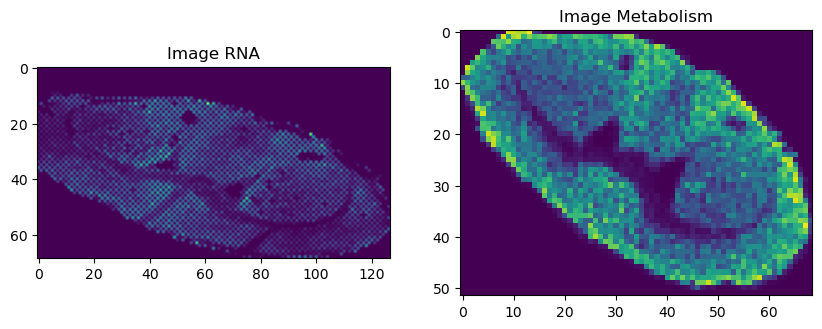

In [7]:
# plot rna and msi
max_x, max_y = rna_adata.obs['array_row'].values.max(), rna_adata.obs['array_col'].values.max()  

vis_rna_array = np.zeros((max_x + 1, max_y + 1))
array_rna = rna_adata.X.toarray()

for i in range(rna_adata.shape[0]):
    temp_x, temp_y = rna_adata.obs['array_row'][i], rna_adata.obs['array_col'][i]
    vis_rna_array[temp_x, temp_y] = array_rna[i, :].sum()

print("rna array shape {}".format(vis_rna_array.shape))

max_x, max_y = msi_adata.obs['array_row'].values.max(), msi_adata.obs['array_col'].values.max()

vis_meta_array = np.zeros((max_x + 1, max_y + 1))
whole_meta_array = np.zeros((max_x + 1, max_y + 1, msi_data_array.shape[1]))
print(whole_meta_array.shape)
print(msi_data_array.shape)


for i in range(msi_adata.X.shape[0]):
    temp_x, temp_y = msi_adata.obs['array_row'][i], msi_adata.obs['array_col'][i]      #max_y - spatial_ori[i, 1]

    vis_meta_array[temp_x, temp_y] = msi_data_array_ori[i, msi_final_mask].sum() 
    whole_meta_array[temp_x, temp_y, :] = msi_data_array_ori[i, :]

print("rna array shape {}".format(vis_meta_array.shape))

# visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(vis_rna_array)
axs[0].set_title('Image RNA')
axs[0].axis('on') 

axs[1].imshow(vis_meta_array)
axs[1].set_title('Image Metabolism')
axs[1].axis('on') 

plt.show()

### Visualize the original data and landmarks

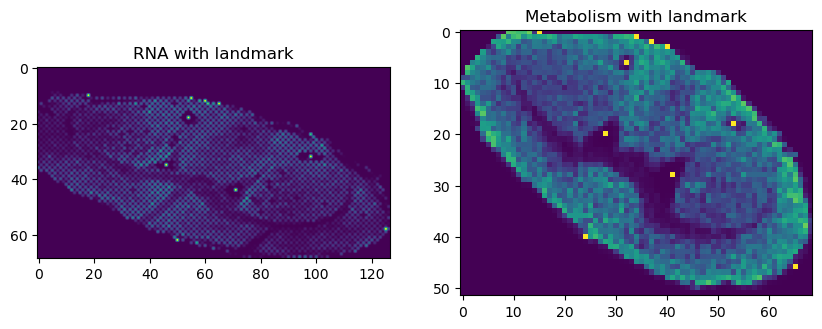

In [8]:
vis_rna_array = vis_rna_array/vis_rna_array.max() * 200
for [x, y] in points_rna:
    vis_rna_array[y, x] = 255

vis_meta_array = vis_meta_array / vis_meta_array.max() * 200
for [x, y] in points_meta:
    vis_meta_array[y, x] = 255

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(vis_rna_array)
axs[0].set_title('RNA with landmark')
axs[0].axis('on')

axs[1].imshow(vis_meta_array)
axs[1].set_title('Metabolism with landmark')
axs[1].axis('on')

plt.show()

### Do the image transformation

In [9]:
points_rna, points_meta = np.float32(points_rna), np.float32(points_meta)

# M, _ = cv2.estimateAffinePartial2D(points2, points1, method=cv2.LMEDS)
# M = cv2.getPerspectiveTransform(points2, points1)
M, _ = cv2.findHomography(points_meta, points_rna, cv2.LMEDS)

# 应用变换到第一张图片
transformed_img = cv2.warpPerspective(vis_meta_array, M, (vis_rna_array.shape[1], vis_rna_array.shape[0]))
# transformed_img = cv2.warpAffine(img_meta, M, (img_rna.shape[1], img_rna.shape[0]))

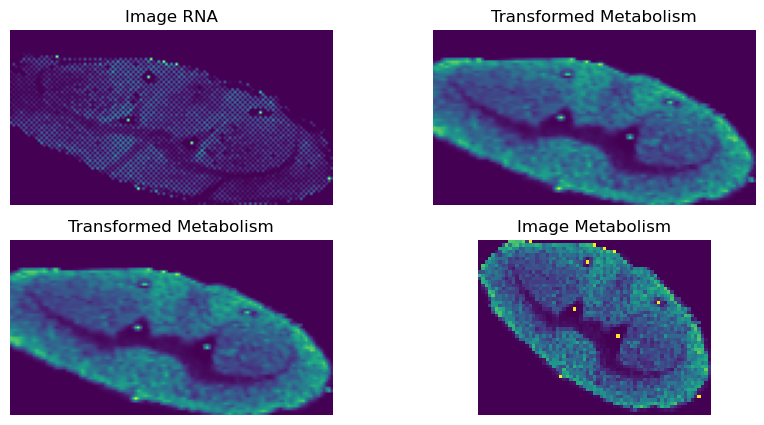

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0, 0].imshow(vis_rna_array)
axs[0, 0].set_title('Image RNA')
axs[0, 0].axis('off') 

axs[0, 1].imshow(transformed_img)
axs[0, 1].set_title('Transformed Metabolism')
axs[0, 1].axis('off') 

axs[1, 0].imshow(transformed_img)
axs[1, 0].set_title('Transformed Metabolism')
axs[1, 0].axis('off') 


axs[1, 1].imshow(vis_meta_array)
axs[1, 1].set_title('Image Metabolism')
axs[1, 1].axis('off')

plt.show()

shape of affined image size (69, 127, 1538)


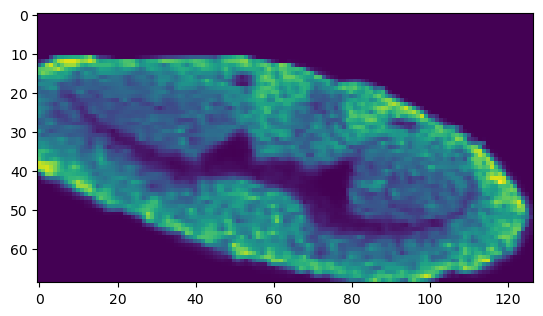

In [11]:
affined_whole_meta = []
for i in range(whole_meta_array.shape[2]):
    affined_whole_meta.append(cv2.warpPerspective(whole_meta_array[:, :, i], M, (vis_rna_array.shape[1], vis_rna_array.shape[0])))

affined_whole_meta = np.stack(affined_whole_meta, axis=2)

print('shape of affined image size {}'.format(affined_whole_meta.shape))
plt.imshow(affined_whole_meta[:, :, msi_final_mask].sum(axis=2))


In [12]:
array_row, array_col, array_msi_value = [], [], []
for i in range(affined_whole_meta.shape[0]):
    for j in range(affined_whole_meta.shape[1]):
        
        temp = affined_whole_meta[i, j, :]
        if temp.sum() == 0:
            continue
        else:
            array_row.append(i)
            array_col.append(j)
            array_msi_value.append(temp)

array_row, array_col, array_msi_value = np.array(array_row), np.array(array_col), np.stack(array_msi_value, axis=0)

In [13]:
saving_array_msi_value = csr_matrix(array_msi_value, dtype=np.float32)
saving_msi_adata = ad.AnnData(saving_array_msi_value)

saving_msi_adata.obs['array_row'], saving_msi_adata.obs['array_col'] = array_row, array_col
saving_msi_adata.obsm['spatial'] = saving_msi_adata.obs[['array_col', 'array_row']].values

In [14]:
saving_msi_adata.var['metabolism'] = np.array(msi_file.columns[2:].tolist())

### Visualize RNA and transformed MSI using scanpy

/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


<Axes: title={'center': 'Expression of rna'}, xlabel='spatial1', ylabel='spatial2'>

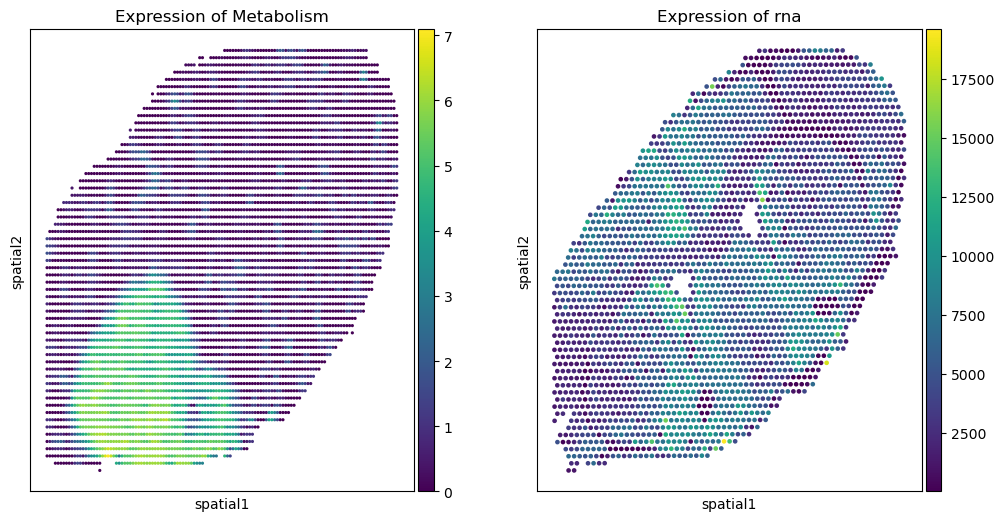

In [15]:
sc.pp.highly_variable_genes(saving_msi_adata, flavor="seurat_v3", n_top_genes=2)
sc.pp.normalize_total(saving_msi_adata, target_sum=1e4)
sc.pp.log1p(saving_msi_adata)

saving_msi_adata.obs['sum'] = saving_msi_adata.X[:, saving_msi_adata.var['highly_variable']].sum(axis=1)


rna_adata.obs['sum'] = rna_adata.X.toarray().sum(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# sc.pl.spatial(saving_msi_adata, basis='spatial', color='sum', title=f'Expression of Metabolism', ax=ax, show=False)
sc.pl.embedding(saving_msi_adata, basis='spatial', color='sum', title=f'Expression of Metabolism', ax=axs[0], show=False)
sc.pl.embedding(rna_adata, basis='spatial', color='sum', title=f'Expression of rna', ax=axs[1], show=False)